# Modélisation des sujets avec Apache Spark ML sur un jeu de données StockOverflow

## Contents <br>

1. Installation des paquets tiers<br>
2. Importation<br>
3. Prepreocessing<br>
4. Finding  Important Concepts <br>
5. Term-Term Relevance<br>
    5.1. Local Implementation<br>
    5.2. Distributed Implementation<br>
6. Document-Document Relevance<br>
7. Term-Document Relevance<br>
8. Multiple-Term Queries<br>

## 1. Installation de paquets

In [1]:
# !pip install pyspark

In [2]:
!pip install abbreviations

In [3]:
!pip install wordcloud

## 2. Importation

In [4]:
# Native python libraries
import re
import json
import time
import math
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler as StandardScaler_skl

In [5]:
# Third-party python libraries
import nltk
import umap
import spacy
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from sklearn.manifold import TSNE
from abbreviations import schwartz_hearst

In [6]:
# Spark libraries for python
from pyspark.sql import Row
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, col, monotonically_increasing_id
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF, StandardScaler
from pyspark.mllib.linalg.distributed import *
from pyspark.mllib.linalg import Vectors, DenseMatrix

## 3. Preprocessing

### 3.1. Initialisation de l'application 

In [7]:
warnings.simplefilter("ignore")

In [8]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/nama/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
sns.set(style="ticks", color_codes=True)

In [10]:
nlp = spacy.load('en_core_web_sm', disable=["parser", "ner", "textcat"])

In [11]:
# Create a SparkSession
spark = (SparkSession.builder.appName("projetRCP216App").getOrCreate())

22/03/28 19:46:05 WARN Utils: Your hostname, Nama resolves to a loopback address: 127.0.1.1; using 192.168.1.6 instead (on interface wlo1)
22/03/28 19:46:05 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/03/28 19:46:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [12]:
# Get spark context
sc = spark.sparkContext

### 3.2. Charger les données dans la structure DataFrame

In [13]:
file = "data/posts.csv"

In [14]:
df = pd.read_csv(file)

In [15]:
df = df[["Body","Title","Tags"]]

In [16]:
df.shape

(5240, 3)

In [17]:
doc_titles = df["Title"].tolist()

In [18]:
df = spark.createDataFrame(df) 

In [19]:
df = df.withColumn("Id", monotonically_increasing_id())

In [20]:
df = df.select("Id","Body","Title","Tags")

In [21]:
doc_titles[0]

'Validate decimal numbers in JavaScript - IsNumeric()'

In [22]:
df.show(5)

+---+--------------------+--------------------+--------------------+
| Id|                Body|               Title|                Tags|
+---+--------------------+--------------------+--------------------+
|  0|<p>What's the cle...|Validate decimal ...|<javascript><vali...|
|  1|<p>I'm designing ...|List of standard ...|<database><standa...|
|  2|<p>What's the eas...|Simplest way to p...|    <php><profiling>|
|  3|<p>Is there any w...|How can I develop...|<ios><iphone><win...|
|  4|<p>I am looking f...|Batch file to del...|<windows><date><b...|
+---+--------------------+--------------------+--------------------+
only showing top 5 rows



In [23]:
df.select([count(F.when(F.isnan(c), c)).alias(c) for c in df.columns[1:]]).show()

+----+-----+----+
|Body|Title|Tags|
+----+-----+----+
|   0|    0|   0|
+----+-----+----+



In [24]:
def shapeDataFrame(d):
    print((d.count(), len(d.columns)))

In [25]:
shapeDataFrame(df)

(5240, 4)


In [26]:
def ave_word_document(df):
    df_wc = df.withColumn('wc_body', F.size(F.split(F.col('Body'), ' ')))
    len_text_body = df_wc.select(F.sum('wc_body')).collect()[0][0]
    df_wc = df_wc.withColumn('wc_title', F.size(F.split(F.col('Title'), ' ')))
    len_text_title = df_wc.select(F.sum('wc_title')).collect()[0][0]
    ave_wc_doc = (len_text_body + len_text_title) / df.count()
    df_wc = df_wc.select(((col("wc_body") + col("wc_title"))).alias("sum"))
    print("Nombre moyen de mots par documents : {}".format(ave_wc_doc))
    return ave_wc_doc

In [27]:
ave_wc_doc = ave_word_document(df)

Nombre moyen de mots par documents : 122.32309160305344


In [28]:
df = df.select(F.concat_ws(' ',df.Body, df.Title).alias("Corpus"), "Id", "Body",
               "Title", "Tags").select("Id","Body","Title","Tags", "Corpus")

### 3.3. Suppression des balises html 

In [29]:
def delete_html_tags(row):
    corpus = BeautifulSoup(str(row['Corpus']), 'html.parser').get_text()
    return (row["Id"], row['Body'], row['Title'], row['Tags'], corpus)

In [30]:
df = df.rdd.map(delete_html_tags).toDF(["Id", "Body", "Title", "Tags",
                                        "Corpus"])

In [31]:
df.show(5)

+---+--------------------+--------------------+--------------------+--------------------+
| Id|                Body|               Title|                Tags|              Corpus|
+---+--------------------+--------------------+--------------------+--------------------+
|  0|<p>What's the cle...|Validate decimal ...|<javascript><vali...|What's the cleane...|
|  1|<p>I'm designing ...|List of standard ...|<database><standa...|I'm designing a d...|
|  2|<p>What's the eas...|Simplest way to p...|    <php><profiling>|What's the easies...|
|  3|<p>Is there any w...|How can I develop...|<ios><iphone><win...|Is there any way ...|
|  4|<p>I am looking f...|Batch file to del...|<windows><date><b...|I am looking for ...|
+---+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



### 3.4. Mettre le corpus en minuscules 

In [32]:
# LowerCase
def lowercase(row):
    corpus = row["Corpus"].lower().strip()
    return (row["Id"], row["Body"], row["Title"], row["Tags"], corpus)

In [33]:
df = df.rdd.map(lowercase).toDF(["Id", 'Body', 'Title', 'Tags', 'Corpus'])

In [34]:
df.show(5)

+---+--------------------+--------------------+--------------------+--------------------+
| Id|                Body|               Title|                Tags|              Corpus|
+---+--------------------+--------------------+--------------------+--------------------+
|  0|<p>What's the cle...|Validate decimal ...|<javascript><vali...|what's the cleane...|
|  1|<p>I'm designing ...|List of standard ...|<database><standa...|i'm designing a d...|
|  2|<p>What's the eas...|Simplest way to p...|    <php><profiling>|what's the easies...|
|  3|<p>Is there any w...|How can I develop...|<ios><iphone><win...|is there any way ...|
|  4|<p>I am looking f...|Batch file to del...|<windows><date><b...|i am looking for ...|
+---+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



### 3.5. Tokeniser le corpus

In [35]:
tokenizer_corpus = Tokenizer(inputCol="Corpus", outputCol="Corpus_tokenized")

In [36]:
df = tokenizer_corpus.transform(df)

In [37]:
df.select("Corpus", "Corpus_tokenized").show(5)

+--------------------+--------------------+
|              Corpus|    Corpus_tokenized|
+--------------------+--------------------+
|what's the cleane...|[what's, the, cle...|
|i'm designing a d...|[i'm, designing, ...|
|what's the easies...|[what's, the, eas...|
|is there any way ...|[is, there, any, ...|
|i am looking for ...|[i, am, looking, ...|
+--------------------+--------------------+
only showing top 5 rows



### 3.6. Remplacer les abbréviations par leur forme longue

In [38]:
def detection_abbreviation(row):
    body = schwartz_hearst. \
    extract_abbreviation_definition_pairs(doc_text=row["Body"],
                                          most_common_definition=True)
    title = schwartz_hearst. \
    extract_abbreviation_definition_pairs(doc_text=row["Title"],
                                          most_common_definition=True)
    return (json.dumps(body), json.dumps(title))

In [39]:
df_abbr = df.rdd.map(detection_abbreviation).toDF(['Body', 'Title'])

Traceback (most recent call last):
  File "/opt/spark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/opt/spark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 643, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/opt/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError


In [40]:
dic_abbr_body = [ex["Body"] for ex in df_abbr.where(~col("Body"). \
                contains("{}")).select(col("Body")).collect()]
dic_abbr_body = [json.loads(ab) for ab in dic_abbr_body]

dic_abbr_title = [ex["Title"] for ex in df_abbr.where(~col("Title"). \
                 contains("{}")).select(col("Title")).collect()]
dic_abbr_title = [json.loads(ab) for ab in dic_abbr_title]

In [41]:
dic_abbr_list = dic_abbr_body + dic_abbr_title

In [42]:
dic_abbreviations = {}
for elt in dic_abbr_list:
    for key in elt.keys():
        if key not in dic_abbreviations.keys():
            dic_abbreviations[key] = elt[key]

In [43]:
dic_abbreviations

{'LSP': 'Liskov Substitution  Principle',
 'ORM': 'Object-Relational mapping',
 'DMG': 'disk image',
 'Private': 'possible to use <a href="http://www.otierney.net/objective-c.html#categories" rel="noreferrer">categories</a> [e.g. MyClass',
 "EJB's": 'Enterprise JavaBeans',
 "VO's": 'Value Objects',
 'file': 'FileReader',
 'Cars[]': 'cars =',
 'FP': 'functional programming',
 'C#': 'code example of that',
 'Spinner': 'spinner =',
 'IoC': 'Inversion of Control</a>',
 'CA': 'Certificate Authority',
 'small': 's only available from a multi-level popup triggered by the',
 'i++': 'i =',
 'u++': 'u =',
 'companyId': 'CompanyId foreign key',
 'Button': 'button =',
 'TFS': 'Team Foundation Server',
 'FRP': 'functional reactive programming',
 'DEBUG': 'debug_print(args ...) if',
 'jwt': 'JSON Web Tokens',
 'CI': 'Continuous Integration',
 'name': 'null parameter',
 'nodeback': 'Node style callback',
 'DAO': 'Data Access Objects',
 'DDD': 'Domain-Driven Design',
 'TDD': 'Test-Driven Development',

In [44]:
len(dic_abbreviations)

88

In [45]:
dic_abbreviations = {'fk': 'foreign keys', 'ref': 'reference', 'dmg': 'disk image', 'orm': 'object-relational mapping', 'ios4?': 'iphone os 4.0', 'ioc': 'inversion of control',
                     'abs': 'absolute value', 'fouc': 'flash of unstyled content', 'mro': 'method resolution order', 'int': 'integers', 'pil': 'python imaging library',
                     'csrf': 'cross-site request forgeries', 'lkml': 'linux kernel mailing list', 'sti': 'single table inheritance', 'el': 'expression languages', 'dfs': 'depth-first search',
                     'iis': 'information services', 'bom': 'byte order mark', 'oop': 'object-oriented programming', 'aop': 'aspect-oriented programming', 
                     'ict': 'in-circuit testing', 'dex': 'dalvik executable', 'cli': 'command line', 'ctes': 'common table expressions', "adt's": 'abstract data types',
                     'dvcs': 'distributed version control systems', 'vba': 'visual basic for applications', 'pcc': 'persisted-computed-columns', 'tee': 'trusted execution environment',
                     'tcg': 'trusted computing group', 'tss': 'tcb software stack', 'cng': 'crypto-next-gen', 'pid': 'process id', 'ppid': 'parent pid', 'vo': 'value objects',
                     'mosa': 'managed operating system alliance', 'uac': 'user account control', 'typos': 'typing errors', 'fifo': 'first-in-first-out', 'tfs': 'team foundation server',
                     'wpf': 'windows presentation foundation', 'jre': 'java runtime environment', 'jdk': 'java development kit', 'px': 'pixel', 'vbos': 'vertex-buffer-objects',
                     're': 'regex', 'mef': 'managed extensibility framework', 'abi': 'application binary interface', 'isa': 'instruction set architecture',
                     'cqrs': 'command query responsibility segregation', 'cci': 'common compiler infrastructure', 'dile': 'dotnet il editor', 'bdd': 'behavior driven development',
                     'anr': 'application not responding','ef': 'entity framework', 'sso': 'single sign on', 'arc': 'automatic reference counting', 'tdd': 'test driven development',
                     'lru': 'least recently used', 'ca': 'certificate authority', 'csp': 'content security policy', 'ci': 'continuous integration', 'di': 'dependency injections',
                     'spa': 'single page application', 'lsp': 'liskov substitution  principle', 'wamp': 'web application messaging protocol', 'bsts': 'binary search trees',
                     'jwt': 'json web tokens', 'tts': 'text to speech', 'nltk': 'natural language toolkit', 'dsl': 'domain-specific language', 'aot': 'ahead of time', 'mvp': 'model–view–presenter',
                     'csv': 'comma separated value', 'crud': 'create, read, update and delete', 'slsb': 'stateless session bean', "ejb's": 'enterprise javabeans', 'jsp': 'java server pages',
                     "dto's": 'data transfer objects', "vo's": 'value objects', 'jpql': 'java persistence query language', 'dto': 'data transfer object', 'sta': 'single threaded apartment',
                     'dylibs': 'dynamic libraries to my project', 'loh': 'large object heap', 'tlrbsf': 'typically-long-running-but-sometimes-fast', 'ifs': 'internal_field_separator',
                     'hdfs': 'hadoop distributed file system', 'javac': 'java compiler', 'nnbd': 'non-nullable by default', 'ndc': 'normalized device space', 'jpf': 'java plugin framework',
                     'jspf': 'java simple plugin framework', 'lda': 'latent dirichlet allocation', 'whnf': 'weak head normal form', 'nf': 'normal form', 'kb': 'knowledge base',
                     'vcs': 'version control systems', 'th': 'table headers', 'cte': 'common table expression', 'ram': 'remain in memory', 'pst': 'pacific standard time', 'hft': 'high frequency trading',
                     'nlp': 'natural language processing', 'gc': 'garbage collector', 'ab': 'apache bench tool', 'otp': 'one time password', 'cors': 'cross origin resource sharing',
                     "dll's": 'dynamic linked libraries', 'cms': 'content management system', 'gil': 'global interpreter lock', 'gpl': 'general public license', 'dao': 'data access objects',
                     'ddd': 'domain-driven design', 'toc': 'table of contents', 'mpl': 'matplotlib', 'etv': 'estimated true value', 'rbm': 'restricted boltzmann machine', 'pfs': 'primefaces selectors',
                     'iaca': 'intel® architecture code analyzer', 'tco': 'tail recursion optimization', 'apig': 'api gateway', 'cf': 'cloudfront', 'vif': 'variance inflation factor',
                     'agu': 'address generation unit', 'vms': 'virtual machines', 'amd': 'asynchronous module definition', 'jvms': 'java virtual machine specifications', 'rpc': 'remote procedure call',
                     'sqs': 'simple queuing service', 'gdb': 'gnu debugger', 'jaxp': 'java api for xml processing', 'nop': 'no-operation', 'sp': 'streaming processors', 'jsse': 'java secure socket extension',
                     'dbproject': 'database project', 'em': 'expectation maximization', 'pca': 'principal component analysis', 'svd': 'singular value decomposition', 'ssas': 'sql server analysis services',
                     'cas': 'compare-and-swap', 'csps': 'content security policies', 'ssms': 'sql server management studio', 'fp': 'functional programming', 'cef': 'chromium embedded framework',
                     'gwt': 'google web toolkit', 'waf': 'wpf application framework', 'rssi': 'received signal strength indicator', 'symlink': 'symbolic link', 'soa': 'service-oriented architecture',
                     'mom': 'message-oriented middleware', 'vss': 'visual sourcesafe', 'ga': 'google analytics', 'fft': 'fast fourier transform', 'ipython': 'interactive python', 'stdin': 'standard input',
                     'vaw': 'view as window"', 'ide': 'integrated development environment', 'dso': 'dynamic shared object', 'ssi': 'server-side includes', 'ipn': 'instant payment notification',
                     'pdt': 'payment data transfer', 'aws': 'amazon web service', 'fbo': 'framebuffer object', 'aut': 'acceptance unit testing', 'dwr': 'direct web remoting', 'cmd': 'command window',
                     'mvc': 'model–view–controller', 'sai': 'scala actor implementations', 'spi': 'service provider interface', 'api': 'application programming interface', 'ssca': 'self-signed ca',
                     'ssc': 'self-signed certificate', 'msm': 'meta state machine', 'rdd': 'resilient distributed dataset', 'cdf': 'cumulative distribution function', 'avd': 'android virtual device',
                     'rx': 'reactive extensions', 'sse': 'server-sent events', 'clr': 'common language runtime', 'oom': 'out of memory', 'df': 'data frame', 'bpa': 'ball pivoting algorithm',
                     'frp': 'functional reactive programming', 'hateoas': 'hypermedia as the engine of application state"', 'vpd': 'virtual private database', 'gp': 'genetic programming',
                     'nfe': 'named function expression', 'pr': 'preflight', 'rr': 'real request', 'ace': 'adaptive communication environment', 'sm': 'streaming multiprocessor', 'odr': 'one definition rule',
                     'fab': 'floatingactionbutton', 'clt': 'command line tools', 'spoj': 'sphere online judge', 'corba': 'common object request broker architecture', 'dtos': 'data transfer objects',
                     'cti': 'class table inheritance', 'wsl': 'windows subsystem for linux', 'gae': 'google app engine', 'cdi': 'contexts and dependency injection', 'spel': 'spring expression language',
                     'jit': 'just-in-time', 'bfs': 'breadth first search', 'eof': 'end of file', 'vs': 'visual studio', 'stddev': 'standard deviation', 'nbsp': 'non-breaking spaces',
                     'dbms': 'database management system', 'cgi': 'common gateway interface', 'tld': 'top-level domain name', 'gas': 'gnu assembler', 'asts': 'abstract syntax trees',
                     'irb': 'interactive ruby console', 'rest': 'representational state transfer', 'soap': 'simple object access protocol', 'adb': 'android debug bridge', 'roc': 'receiving operating characteristic',
                     'bit-shift': 'bitwise shift', 'dht': 'distributed hash table', 'fts': 'full text search', 'kvo': 'key-value observation', 'stl': 'standard library', 'svn': 'subversion',
                     'rmse': 'root mean square error', 'gtest': 'google c++ testing framework', 'aio': 'asynchronous i/o', 'rbac': 'role-based access control', 'sstable': 'sorted string table',
                     'regex': 'regular expressions', 'ota': 'over the air', 'cbac': 'claims-based access control', 'eav': 'entity-attribute-value', 'crtp': 'curiously recurring template pattern',
                     'l&f': 'look and feel', 'asi': 'automatic semicolon insertion', 'er': 'entity-relationship', 'pdb': "python's own debugger", 'rtl': 'remote test laboratory', 'bst': 'binary search tree',
                     'sbt': 'simple-build-tool', 'wss': 'websockets and enable ssl', 'dind': 'docker-in-docker', 'vscode': 'visual studio code', 'camelcase': 'camel case', 'rss': 'resident set size',
                     'ffi': 'foreign function interface', 'ai': 'artificial intelligence'
}

In [46]:
def remove_abbreviations(values):
    words = []
    for val in values:
        if val in dic_abbreviations.keys():
            val = re.sub(val, dic_abbreviations[val], val)
        words.append(val)
    return words

In [47]:
udfremove_abbreviations = F.udf(remove_abbreviations, ArrayType(StringType()))

In [48]:
df = df.withColumn("Corpus_remove_abbreviations",
                   udfremove_abbreviations("Corpus_tokenized"))

In [49]:
df.where(col("Id").between(30, 35)).select("Corpus_tokenized",
          "Corpus_remove_abbreviations").show(5)

+--------------------+---------------------------+
|    Corpus_tokenized|Corpus_remove_abbreviations|
+--------------------+---------------------------+
|[i'm, asking, wit...|       [i'm, asking, wit...|
|[using, c#, and, ...|       [using, c#, and, ...|
|[how, would, one,...|       [how, would, one,...|
|[given, two, diff...|       [given, two, diff...|
|[is, there, a, go...|       [is, there, a, go...|
+--------------------+---------------------------+
only showing top 5 rows



### 3.7. Remplacer les contractions par leur forme longue

In [50]:
with open('data/dic_contractions.txt') as f:
    dic_contractions = json.loads("".join(f.readlines()))

In [51]:
for key in dic_contractions.keys():
    dic_contractions[key] = dic_contractions[key].split("/")[0].strip()

In [52]:
dic_contractions

{"ain't": 'am not',
 "aren't": 'are not',
 "can't": 'cannot',
 "can't've": 'cannot have',
 "'cause": 'because',
 "could've": 'could have',
 "couldn't": 'could not',
 "couldn't've": 'could not have',
 "didn't": 'did not',
 "doesn't": 'does not',
 "don't": 'do not',
 "hadn't": 'had not',
 "hadn't've": 'had not have',
 "hasn't": 'has not',
 "haven't": 'have not',
 "he'd": 'he had',
 "he'd've": 'he would have',
 "he'll": 'he shall',
 "he'll've": 'he shall have',
 "he's": 'he has',
 "how'd": 'how did',
 "how'd'y": 'how do you',
 "how'll": 'how will',
 "how's": 'how has',
 "i'd": 'i had',
 "i'd've": 'i would have',
 "i'll": 'i shall',
 "i'll've": 'i shall have',
 "i'm": 'i am',
 "i've": 'i have',
 "isn't": 'is not',
 "it'd": 'it had',
 "it'd've": 'it would have',
 "it'll": 'it shall',
 "it'll've": 'it shall have',
 "it's": 'it has',
 "let's": 'let us',
 "ma'am": 'madam',
 "mayn't": 'may not',
 "might've": 'might have',
 "mightn't": 'might not',
 "mightn't've": 'might not have',
 "must've": '

In [53]:
def remove_contract_form(values):
    words = []
    for val in values:
        for key in dic_contractions.keys():
            val = re.sub(key, dic_contractions[key], val)
        words.extend(val.split())
    return words

In [54]:
udfremove_contract_form = F.udf(remove_contract_form, ArrayType(StringType()))

In [55]:
df = df.withColumn("Corpus_remove_contractions",
                   udfremove_contract_form("Corpus_remove_abbreviations"))

In [56]:
df.select("Corpus_remove_abbreviations",
          "Corpus_remove_contractions").show(5)

+---------------------------+--------------------------+
|Corpus_remove_abbreviations|Corpus_remove_contractions|
+---------------------------+--------------------------+
|       [what's, the, cle...|      [what, has, the, ...|
|       [i'm, designing, ...|      [i, am, designing...|
|       [what's, the, eas...|      [what, has, the, ...|
|       [is, there, any, ...|      [is, there, any, ...|
|       [i, am, looking, ...|      [i, am, looking, ...|
+---------------------------+--------------------------+
only showing top 5 rows



### 3.8. Suppression des StopWords

In [57]:
remover_corpus = StopWordsRemover(inputCol="Corpus_remove_contractions",
                                  outputCol="Corpus_remove_STOP_WORDS")


In [58]:
df = remover_corpus.transform(df)

In [59]:
df.select("Corpus_remove_contractions",
          "Corpus_remove_STOP_WORDS").show(5)

+--------------------------+------------------------+
|Corpus_remove_contractions|Corpus_remove_STOP_WORDS|
+--------------------------+------------------------+
|      [what, has, the, ...|    [cleanest,, effec...|
|      [i, am, designing...|    [designing, datab...|
|      [what, has, the, ...|    [easiest, way, pr...|
|      [is, there, any, ...|    [way, tinker, iph...|
|      [i, am, looking, ...|    [looking, way, de...|
+--------------------------+------------------------+
only showing top 5 rows



### 3.9. Supperssion des caractères spéciaux 

In [60]:
def remove_special_characters(values):
    words = []
    for val in values:
        val = re.sub(re.compile(r'[^a-z ]'), "", val)
        val = val.strip()
        if val != "": 
            words.append(val)
    return words

In [61]:
udfremove_special_characters = F.udf(remove_special_characters,
                                     ArrayType(StringType()))

In [62]:
df = df.withColumn("Corpus_remove_special_characters",
                   udfremove_special_characters("Corpus_remove_STOP_WORDS"))

In [63]:
df.where(col("Id").between(10, 15)).select("Corpus_remove_STOP_WORDS",
                                           "Corpus_remove_special_characters").show(5)

+------------------------+--------------------------------+
|Corpus_remove_STOP_WORDS|Corpus_remove_special_characters|
+------------------------+--------------------------------+
|    [want, know, "vir...|            [want, know, virt...|
|    [c, c++, programm...|            [c, c, programmin...|
|    [favorite, (g)vim...|            [favorite, gvim, ...|
|    [long, ago, begin...|            [long, ago, begin...|
|    [difference, unio...|            [difference, unio...|
+------------------------+--------------------------------+
only showing top 5 rows



### 3.10. Suppression des tokens de taille inférieur à 3

In [64]:
def remove_length_less3(values):
    words = []
    for val in values:
        if len(val) > 2:
            words.append(val)
    return words

In [65]:
udfremove_length_less3 = F.udf(remove_length_less3, ArrayType(StringType()))

In [66]:
df = df.withColumn("Corpus_remove_length_less3",
                   udfremove_length_less3("Corpus_remove_special_characters"))

In [67]:
df.where(col("Id").between(10, 15)).select("Corpus_remove_special_characters",
                                           "Corpus_remove_length_less3").show(5)

+--------------------------------+--------------------------+
|Corpus_remove_special_characters|Corpus_remove_length_less3|
+--------------------------------+--------------------------+
|            [want, know, virt...|      [want, know, virt...|
|            [c, c, programmin...|      [programming, lan...|
|            [favorite, gvim, ...|      [favorite, gvim, ...|
|            [long, ago, begin...|      [long, ago, begin...|
|            [difference, unio...|      [difference, unio...|
+--------------------------------+--------------------------+
only showing top 5 rows



### 3.11. Lémmatisation du corpus

In [68]:
nlp = spacy.load('en_core_web_sm', disable=["parser", "ner", "textcat"])

In [69]:
def lemmatization(values):
    words = []
    for val in values:
        doc = nlp(val)
        words.append(doc[0].lemma_)
    return words

In [70]:
udflemmatization = F.udf(lemmatization, ArrayType(StringType()))

In [71]:
df = df.withColumn("Corpus_lemmatized",
                   udflemmatization("Corpus_remove_length_less3"))

In [72]:
df.select("Corpus_remove_length_less3", "Corpus_lemmatized").show(5)

+--------------------------+--------------------+
|Corpus_remove_length_less3|   Corpus_lemmatized|
+--------------------------+--------------------+
|      [cleanest, effect...|[clean, effective...|
|      [designing, datab...|[design, database...|
|      [easiest, way, pr...|[easy, way, profi...|
|      [way, tinker, iph...|[way, tinker, iph...|
|      [looking, way, de...|[look, way, delet...|
+--------------------------+--------------------+
only showing top 5 rows



### 3.12. Mots clés potentiels 

In [73]:
def potential_keywords(values):
    words = []
    for val in values:
        doc = nlp(val)
        if doc[0].pos_ in ['NOUN', 'VERB', 'ADJ']:
            words.append(val)
    return words

In [74]:
udfpotential_keywords = F.udf(potential_keywords, ArrayType(StringType()))

In [75]:
df = df.withColumn("Corpus_potential_keywords",
                   udfpotential_keywords("Corpus_lemmatized"))

In [76]:
df.select("Corpus_potential_keywords").show(5)

+-------------------------+
|Corpus_potential_keywords|
+-------------------------+
|     [effective, way, ...|
|     [design, database...|
|     [easy, way, profi...|
|     [way, tinker, iph...|
|     [look, way, delet...|
+-------------------------+
only showing top 5 rows



In [77]:
def array_to_text(values):
    return ' '.join(values)

In [78]:
udfarray_to_text = F.udf(array_to_text, StringType())

In [79]:
df = df.withColumn("Corpus_cleaned", udfarray_to_text("Corpus_lemmatized"))

In [80]:
df.select("Corpus_cleaned").show(10)

+--------------------+
|      Corpus_cleaned|
+--------------------+
|clean effective w...|
|design database t...|
|easy way profile ...|
|way tinker iphone...|
|look way delete f...|
|question talk dif...|
|query store proce...|
|good way remove d...|
|work project invo...|
|cnet dependency i...|
+--------------------+
only showing top 10 rows



In [81]:
df.printSchema()

root
 |-- Id: long (nullable = true)
 |-- Body: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Tags: string (nullable = true)
 |-- Corpus: string (nullable = true)
 |-- Corpus_tokenized: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- Corpus_remove_abbreviations: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- Corpus_remove_contractions: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- Corpus_remove_STOP_WORDS: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- Corpus_remove_special_characters: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- Corpus_remove_length_less3: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- Corpus_lemmatized: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- Corpus_potential_keywords: array (nullable = true)
 |    |-- element: string (containsNull

## 4. Statistiques et visualisation du corpus 

In [82]:
corpus_lemmatized = df.select("Corpus_lemmatized").collect()

In [83]:
word_counts = {}
for words in corpus_lemmatized:
    for word in words["Corpus_lemmatized"]:
        if word not in word_counts.keys():
            word_counts[word] = 0
        word_counts[word] += 1

In [84]:
word_counts = {k: v for k, v in sorted(word_counts.items(),
                                       key=lambda item: item[1], reverse=True)}

In [85]:
word_counts

{'use': 5365,
 'file': 2524,
 'like': 2080,
 'get': 2022,
 'code': 1825,
 'git': 1767,
 'way': 1734,
 'want': 1646,
 'work': 1594,
 'one': 1590,
 'new': 1355,
 'try': 1294,
 'function': 1272,
 'find': 1229,
 'example': 1149,
 'need': 1140,
 'string': 1132,
 'know': 1108,
 'class': 1100,
 'create': 1083,
 'make': 1080,
 'datum': 1076,
 'return': 1072,
 'run': 1066,
 'this': 1058,
 'change': 1044,
 'difference': 1043,
 'value': 1035,
 'good': 1018,
 'object': 1011,
 'method': 997,
 'python': 978,
 'question': 966,
 'error': 923,
 'application': 919,
 'set': 907,
 'list': 892,
 'time': 892,
 'see': 892,
 'branch': 859,
 'also': 832,
 'add': 831,
 'line': 824,
 'follow': 824,
 'user': 808,
 'javascript': 795,
 'call': 795,
 'commit': 792,
 'look': 787,
 'public': 776,
 'java': 766,
 'name': 765,
 'seem': 741,
 'server': 739,
 'something': 735,
 'command': 711,
 'type': 674,
 'well': 635,
 'two': 631,
 'write': 624,
 'version': 607,
 'read': 606,
 'understand': 606,
 'give': 602,
 'answer':

In [86]:
len(word_counts)

26484

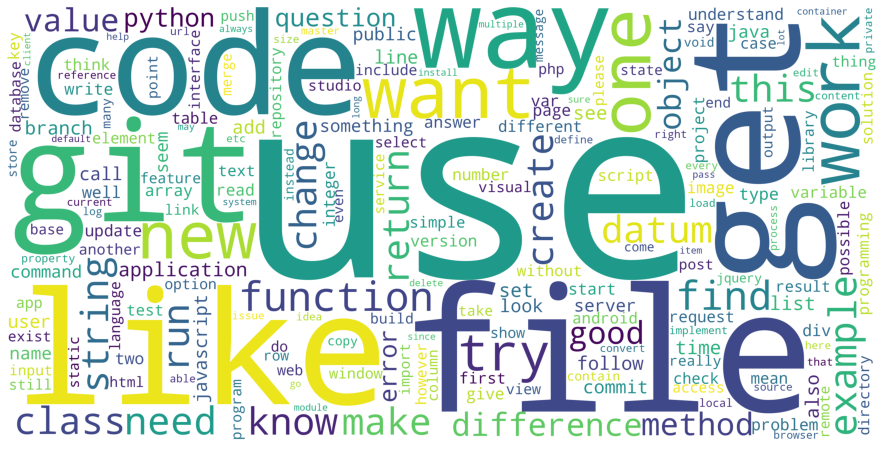

In [87]:
wordcloud = WordCloud(background_color = 'white', height = 2000,
                           width = 4000).generate_from_frequencies(word_counts)
plt.figure(figsize = (16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [88]:
def processing_tags(values):
    x = values.split(">")
    tags = []
    for t in x:
        if t.strip() != "":
            tags.append(t[1:])
    return tags

In [89]:
udfprocessing_tags = F.udf(processing_tags, ArrayType(StringType()))

In [90]:
df = df.withColumn("Tags_processed", udfprocessing_tags("Tags"))

In [91]:
df.select("Tags_processed").show(5)

+--------------------+
|      Tags_processed|
+--------------------+
|[javascript, vali...|
|[database, standa...|
|    [php, profiling]|
|[ios, iphone, win...|
|[windows, date, b...|
+--------------------+
only showing top 5 rows



In [92]:
data = df.select("Corpus_lemmatized")

In [93]:
data.show(5)

+--------------------+
|   Corpus_lemmatized|
+--------------------+
|[clean, effective...|
|[design, database...|
|[easy, way, profi...|
|[way, tinker, iph...|
|[look, way, delet...|
+--------------------+
only showing top 5 rows



In [94]:
del corpus_lemmatized

## 5. TF-IDF

### 5.1. Term Frequency (TF)

le choix de la taille du corpus doit être guidée par le temps de calcul

In [95]:
vocab_size = 2000

In [96]:
cv = CountVectorizer(inputCol="Corpus_lemmatized", outputCol="rawFeatures",
                     vocabSize=vocab_size)

In [97]:
cv_model = cv.fit(data)

In [98]:
featurizedData = cv_model.transform(data)

In [99]:
featurizedData.where(col("Id").between(35, 40)).select("rawFeatures").show(4, truncate=False)

+-----------------------------------------------------------------------------------------------------+
|rawFeatures                                                                                          |
+-----------------------------------------------------------------------------------------------------+
|(2000,[4,50,128,270,700,897,1582],[2.0,2.0,1.0,2.0,2.0,2.0,4.0])                                     |
|(2000,[0,18,57,108,109,687,711],[2.0,2.0,1.0,2.0,2.0,1.0,2.0])                                       |
|(2000,[0,9,26,282,375],[1.0,1.0,2.0,1.0,2.0])                                                        |
|(2000,[0,9,31,202,251,275,282,327,411,465,886,908],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0])|
+-----------------------------------------------------------------------------------------------------+
only showing top 4 rows



### 5.2. Inverse Document Frequency (IDF) 

### 5.3. TF-IDF complet 

In [100]:
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)

In [101]:
documentTermMatrix = idfModel.transform(featurizedData)

In [102]:
documentTermMatrix.where(col("Id").between(86, 86)).select("features").show(1,truncate=False)

+--------------------------------------------------------------------------+
|features                                                                  |
+--------------------------------------------------------------------------+
|(2000,[9,12,26],[1.5888536713462145,2.1773882794395214,4.237095558833176])|
+--------------------------------------------------------------------------+



In [103]:
documentTermMatrix.columns

['Corpus_lemmatized', 'rawFeatures', 'features']

## 6. Latent Semantic Analysis (LSA)

### 6.1. SVD

#### Choix du nombre de sujets : nous nous limitons à 30 pour des raisons de réduction de la complexité d'analyse

In [104]:
n_samples = documentTermMatrix.count()
n_samples

5240

In [105]:
mat = RowMatrix(documentTermMatrix.select("features").rdd. \
                map(lambda v: Vectors.dense(v.features.toArray())).cache())

In [106]:
def explained_variance_ratio_sum(svd, seuil, a):
    s = np.array(svd.s)
    explained_variance_ = (s**2) / (n_samples - 1)
    total_var = explained_variance_.sum()
    explained_variance_ratio_ = explained_variance_ / total_var
    boolean = True
    n_topics = 0
    i = 0
    index = 0
    variances = []
    for k in range(a, s.shape[0], a):
        var = explained_variance_ratio_[:k].sum()
        variances.append(var)
        if var > seuil and boolean:
            print(var)
            n_topics = k
            boolean = False
            index = i
        i += 1
    return variances, n_topics, index

In [107]:
seuil = 0.95

In [108]:
start = time.time()
svd_k = mat.computeSVD(mat.numCols() - 1, computeU=False)
print(str(time.time() - start) + 's')

22/03/28 20:06:26 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/03/28 20:06:26 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
22/03/28 20:10:21 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/03/28 20:10:21 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


373.32229018211365s


In [109]:
cum_variances, n_topics, index = explained_variance_ratio_sum(svd_k, seuil, 100)

0.9607161477694114


In [110]:
# Nombre de sujets
n_topics

1100

In [111]:
num_topic_candidates = range(200, 1400, 100)
variances = cum_variances[index - 9: index+3]

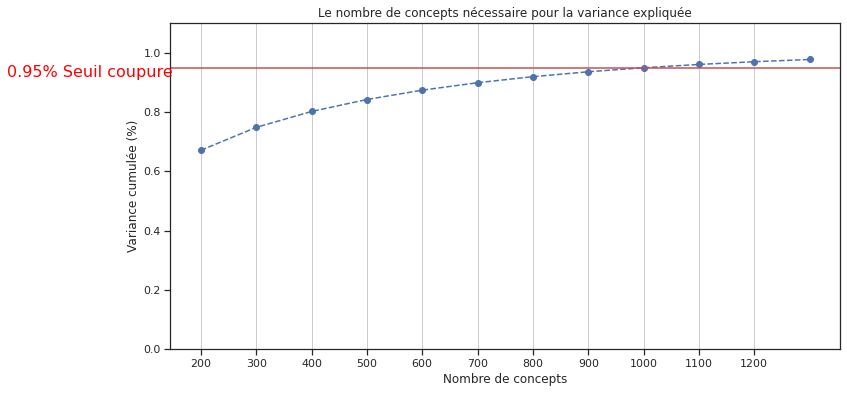

In [112]:
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()

plt.ylim(0.0,1.1)
plt.plot(num_topic_candidates, variances, marker='o', linestyle='--', color='b')

plt.xlabel('Nombre de concepts')
plt.xticks(np.arange(200, 1300, 100))
plt.ylabel('Variance cumulée (%)')
plt.title('Le nombre de concepts nécessaire pour la variance expliquée')

plt.axhline(y=seuil, color='r', linestyle='-')
plt.text(-150, seuil - 0.03, str(seuil) + '% Seuil coupure', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [113]:
start = time.time()
svd = mat.computeSVD(n_topics, computeU=True)
print(str(time.time() - start) + 's')

37.521366596221924s


## 7. Résultats

In [114]:
def terms_in_concepts(svd, num_concepts, termIds):
    topics_terms = []
    V = svd.V
    arr= V.toArray().T
    for num in range(num_concepts):
        weights = arr[num]
        indices = np.argsort(weights).tolist()
        indices.reverse()
        terms = [termIds[i] for i in indices]
        weights = weights[indices]
        res = list(zip(terms, weights))
        topics_terms.append(res)
    return topics_terms

In [115]:
def docs_in_concepts(mat, num_concepts, doc_titles):
    topics_docs = []
    for num in range(num_concepts):
        weights = mat[num]
        indices = np.argsort(weights).tolist()
        indices.reverse()
        docs = [(i, doc_titles[i]) for i in indices]
        weights = weights[indices]
        res = list(zip(docs, weights))
        topics_docs.append(res)
    return topics_docs

In [116]:
def display_top_terms(topics_terms, n_terms, n_topics):
    for i in range(len(topics_terms[:n_topics])):
        print("Topic {}: {}".format(i+1,
              " ".join([elt[0] for elt in topics_terms[i][:n_terms]])))
        print('\n')

In [117]:
def display_top_terms2(topics_terms, n_terms, n_topics):
    for i in range(len(topics_terms[:n_topics])):
        print("Topic {}: ".format(i+1), topics_terms[i][:n_terms])
        print('\n')

In [118]:
def display_top_docs(topics_docs, n_docs, n_topics):
    for i in range(len(topics_docs[:n_topics])):
        print("Topic {}: {}".format(i+1, 
              "   ".join([elt[0][1] for elt in topics_docs[i][:n_docs]])))
        print('\n')

In [119]:
def display_top_docs2(topics_docs, n_docs, n_topics):
    for i in range(len(topics_docs[:n_topics])):
        print("Topic {}: ".format(i+1), topics_docs[i][:n_docs])
        print('\n')

In [120]:
u_rows_collect = svd.U.rows.collect()

In [121]:
u_rows_array = np.array([row.toArray().tolist() for row in u_rows_collect])

### 7.1. Thématique

In [122]:
topics_terms = terms_in_concepts(svd, n_topics, cv_model.vocabulary)

In [123]:
display_top_terms(topics_terms, 10, 6)

Topic 1: hover errorwindowmanager href clipboard checkbox onclick dropdown uitextview dosomethe blah


Topic 2: total grand loadmodule file dot run xamarin java time read


Topic 3: total grand dot xamarin java arm time read run android


Topic 4: null public php git operator branch insert strtok integer image


Topic 5: null strtok insert serrmsg sqliteexecdb sqlite second branch git transaction


Topic 6: git branch commit master merge remote push rebase repository checkout




In [124]:
display_top_terms2(topics_terms, 10, 6)

Topic 1:  [('hover', -0.00040940482165381696), ('errorwindowmanager', -0.0004491390101867952), ('href', -0.0005209422262398035), ('clipboard', -0.0005387638006393046), ('checkbox', -0.0005468011571643271), ('onclick', -0.0005794998441521287), ('dropdown', -0.000601612518927194), ('uitextview', -0.0006031676819529092), ('dosomethe', -0.0006110410584599712), ('blah', -0.0006215772328938966)]


Topic 2:  [('total', 0.26327844056377664), ('grand', 0.18998453285668704), ('loadmodule', 0.15065344753850618), ('file', 0.09686088720510479), ('dot', 0.09673727338246998), ('run', 0.09534922785151013), ('xamarin', 0.08937873855340965), ('java', 0.08696140340315484), ('time', 0.08595434219735819), ('read', 0.07819505330601832)]


Topic 3:  [('total', 0.39876112976748307), ('grand', 0.29152882260371904), ('dot', 0.14715285855791055), ('xamarin', 0.13715475956079237), ('java', 0.1030714225587056), ('arm', 0.09383969329664368), ('time', 0.09274756089121657), ('read', 0.09274292839354631), ('run', 0.08

In [125]:
def draw_word_cloud(index):
    topic_terms = topics_terms[index-1]
    word_size = {}
    for term in topic_terms:
        word_size[term[0]] = int(term[1] * 100)
    wordcloud = WordCloud(background_color = 'white',
                          height = 2000, width = 4000).\
                          generate_from_frequencies(word_size)
    plt.figure(figsize = (12,4))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

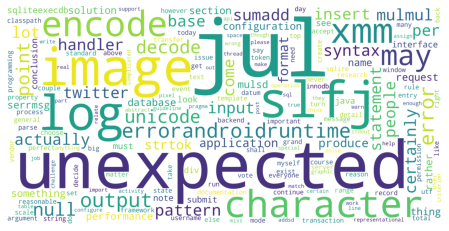

In [126]:
draw_word_cloud(11)

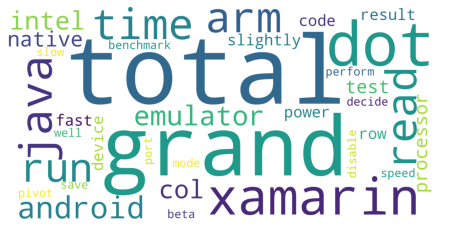

In [127]:
draw_word_cloud(3)

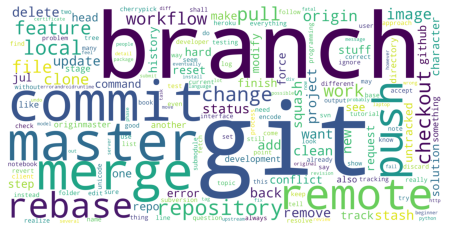

In [128]:
draw_word_cloud(6)

In [129]:
topics_docs = docs_in_concepts(u_rows_array.T, n_topics, doc_titles)

In [130]:
display_top_docs(topics_docs, 3, 6)

Topic 1: What is Mocking?   Favorite (G)Vim plugins/scripts?   Capturing mobile phone traffic on Wireshark


Topic 2: How to compare the performance of Android Apps written in Java and Xamarin C#? Anyway to check quantitative data (code & results)   Error message "Forbidden You don't have permission to access / on this server"   Twitter image encoding challenge


Topic 3: How to compare the performance of Android Apps written in Java and Xamarin C#? Anyway to check quantitative data (code & results)   How can I pivot a dataframe?   In PHP, what is a closure and why does it use the "use" identifier?


Topic 4: Improve INSERT-per-second performance of SQLite   Reference — What does this symbol mean in PHP?   Twitter image encoding challenge


Topic 5: Improve INSERT-per-second performance of SQLite   Git workflow and rebase vs merge questions   How do I achieve the theoretical maximum of 4 FLOPs per cycle?


Topic 6: Git workflow and rebase vs merge questions   Various ways to remove loc

In [131]:
display_top_docs2(topics_docs, 3, 6)

Topic 1:  [((3060, 'What is Mocking?'), -3.086754008870671e-05), ((12, 'Favorite (G)Vim plugins/scripts?'), -6.14180080286643e-05), ((2728, 'Capturing mobile phone traffic on Wireshark'), -0.0001309777322325166)]


Topic 2:  [((4926, 'How to compare the performance of Android Apps written in Java and Xamarin C#? Anyway to check quantitative data (code & results)'), 0.4245061252964962), ((5018, 'Error message "Forbidden You don\'t have permission to access / on this server"'), 0.18882443360177883), ((1783, 'Twitter image encoding challenge'), 0.06380121583269911)]


Topic 3:  [((4926, 'How to compare the performance of Android Apps written in Java and Xamarin C#? Anyway to check quantitative data (code & results)'), 0.5999518944005918), ((2365, 'How can I pivot a dataframe?'), 0.06791937107820774), ((1313, 'In PHP, what is a closure and why does it use the "use" identifier?'), 0.008025800484454873)]


Topic 4:  [((2830, 'Improve INSERT-per-second performance of SQLite'), 0.2975101470787

## 8. Analyse des similarités

In [132]:
U = svd.U
s = svd.s
V = svd.V

In [133]:
U_distributed = sc.parallelize(u_rows_collect).zipWithIndex()
S_distributed =  sc.parallelize(np.diag(s.toArray())).zipWithIndex()
V_distributed =  sc.parallelize(V.toArray()).zipWithIndex()

22/03/28 20:12:25 WARN TaskSetManager: Stage 46 contains a task of very large size (5641 KiB). The maximum recommended task size is 1000 KiB.
22/03/28 20:12:25 WARN TaskSetManager: Stage 47 contains a task of very large size (1185 KiB). The maximum recommended task size is 1000 KiB.
22/03/28 20:12:25 WARN TaskSetManager: Stage 48 contains a task of very large size (2161 KiB). The maximum recommended task size is 1000 KiB.


In [134]:
U_distributed = U_distributed.map(lambda row: IndexedRow(row[1], row[0]))
S_distributed = S_distributed.map(lambda row: IndexedRow(row[1], row[0]))
V_distributed = V_distributed.map(lambda row: IndexedRow(row[1], row[0]))

U_distributed = IndexedRowMatrix(U_distributed).toBlockMatrix()
S_distributed = IndexedRowMatrix(S_distributed).toBlockMatrix()
V_distributed = IndexedRowMatrix(V_distributed).toBlockMatrix()

22/03/28 20:12:26 WARN TaskSetManager: Stage 49 contains a task of very large size (5641 KiB). The maximum recommended task size is 1000 KiB.
22/03/28 20:12:26 WARN TaskSetManager: Stage 50 contains a task of very large size (5641 KiB). The maximum recommended task size is 1000 KiB.
22/03/28 20:12:28 WARN TaskSetManager: Stage 51 contains a task of very large size (5641 KiB). The maximum recommended task size is 1000 KiB.
22/03/28 20:12:28 WARN TaskSetManager: Stage 52 contains a task of very large size (1185 KiB). The maximum recommended task size is 1000 KiB.
22/03/28 20:12:28 WARN TaskSetManager: Stage 53 contains a task of very large size (1185 KiB). The maximum recommended task size is 1000 KiB.
22/03/28 20:12:28 WARN TaskSetManager: Stage 54 contains a task of very large size (1185 KiB). The maximum recommended task size is 1000 KiB.
22/03/28 20:12:28 WARN TaskSetManager: Stage 55 contains a task of very large size (2161 KiB). The maximum recommended task size is 1000 KiB.
22/03/

In [135]:
def normalize_distributed_matrix(mat):
    indexRows = []
    for r in range(mat.numRows):
        row = []
        somme = 0
        for c in range(mat.numCols):
            row.append(mat[r, c])
            somme += mat[r, c] * mat[r, c]
        norme = math.sqrt(somme)
        indexRows.append((r, (np.array(row)/norme).tolist()))
    rows = sc.parallelize(indexRows)
    new_mat = IndexedRowMatrix(rows).toBlockMatrix()
    return new_mat

### 8.1. Termes similaires à un mot/terme 

In [136]:
VS_distributed = V_distributed.multiply(S_distributed)

22/03/28 20:12:29 WARN TaskSetManager: Stage 58 contains a task of very large size (2161 KiB). The maximum recommended task size is 1000 KiB.
22/03/28 20:12:33 WARN TaskSetManager: Stage 60 contains a task of very large size (1185 KiB). The maximum recommended task size is 1000 KiB.


In [137]:
VS_normalized = normalize_distributed_matrix(VS_distributed.toLocalMatrix())

22/03/28 20:12:45 WARN TaskSetManager: Stage 68 contains a task of very large size (2424 KiB). The maximum recommended task size is 1000 KiB.
22/03/28 20:12:45 WARN TaskSetManager: Stage 69 contains a task of very large size (2424 KiB). The maximum recommended task size is 1000 KiB.
22/03/28 20:12:46 WARN TaskSetManager: Stage 70 contains a task of very large size (2424 KiB). The maximum recommended task size is 1000 KiB.


In [138]:
def top_terms_for_term(term, VS, N):
    term = term.lower()
    if term in cv_model.vocabulary:
        term_id = cv_model.vocabulary.index(term)
        mat_temp = VS.toLocalMatrix()
        rowVec = [mat_temp[term_id, j] for j in range(mat_temp.numCols)]
        rowVec = sc.parallelize([IndexedRow(0, rowVec)])
        rowVec = IndexedRowMatrix(rowVec).toBlockMatrix()
        cos_sim = VS.multiply(rowVec.transpose())
        scores = cos_sim.toIndexedRowMatrix().rows.top(N, lambda x: x.vector[0])
    else:
        print("Mot absent du vocabulaire du corpus à la suite du preprocessing")
        return
    return scores

In [139]:
def display_top_terms_term(top_term_scores, num_score):
    results = []
    for term in top_term_scores[1:num_score+1]:
        print((cv_model.vocabulary[term.index], term.vector[0]))

In [140]:
top_term_scores = top_terms_for_term("remote", VS_normalized, 10)

22/03/28 20:12:47 WARN TaskSetManager: Stage 71 contains a task of very large size (2424 KiB). The maximum recommended task size is 1000 KiB.


In [141]:
display_top_terms_term(top_term_scores, 8)

('push', 0.578356491032392)
('git', 0.48551477931855813)
('branch', 0.4805331161886072)
('local', 0.441476317747655)
('origin', 0.42101883907003673)
('master', 0.3767326799184786)
('ref', 0.33281904522686107)
('repository', 0.3307002274546873)


### 8.2. Documents similaires à un mot/terme

In [142]:
US_distributed = U_distributed.multiply(S_distributed)

22/03/28 20:12:59 WARN TaskSetManager: Stage 91 contains a task of very large size (5641 KiB). The maximum recommended task size is 1000 KiB.


In [143]:
US_normalized = normalize_distributed_matrix(US_distributed.toLocalMatrix())

22/03/28 20:13:33 WARN TaskSetManager: Stage 101 contains a task of very large size (6344 KiB). The maximum recommended task size is 1000 KiB.
22/03/28 20:13:33 WARN TaskSetManager: Stage 102 contains a task of very large size (6344 KiB). The maximum recommended task size is 1000 KiB.
22/03/28 20:13:35 WARN TaskSetManager: Stage 103 contains a task of very large size (6344 KiB). The maximum recommended task size is 1000 KiB.


In [144]:
def top_docs_for_term(term, US, svd, N):
    term = term.lower()
    if term in cv_model.vocabulary:
        term_id = cv_model.vocabulary.index(term)
        rowVec = svd.V.toArray()[term_id].tolist()
        rowVec = sc.parallelize([IndexedRow(0, rowVec)])
        rowVec = IndexedRowMatrix(rowVec).toBlockMatrix()
        doc_sco = US.multiply(rowVec.transpose())
        scores = doc_sco.toIndexedRowMatrix().rows.top(N, lambda x: x.vector[0])
    else:
        print("Mot absent du vocabulaire du corpus à la fin du preprocessing")
        return
    return scores

In [145]:
def display_top_docs_term(top_doc_scores, num_score):
    results = []
    for doc in top_doc_scores[:num_score]:
        print((doc.index, doc_titles[doc.index], doc.vector[0]))

In [146]:
top_doc_scores = top_docs_for_term("python", US_normalized,  svd, 10)

22/03/28 20:13:37 WARN TaskSetManager: Stage 111 contains a task of very large size (6344 KiB). The maximum recommended task size is 1000 KiB.


In [147]:
display_top_docs_term(top_doc_scores, 10)

(4786, 'What is the Python 3 equivalent of "python -m SimpleHTTPServer"', 0.8280456285938669)
(911, 'What are metaclasses in Python?', 0.8183768034973554)
(2857, 'Why do people write #!/usr/bin/env python on the first line of a Python script?', 0.8137569191988194)
(2472, 'Python vs Cpython', 0.6746644416590476)
(547, 'What is memoization and how can I use it in Python?', 0.6232437033193609)
(2289, 'Python coding standards/best practices', 0.6200859484887281)
(5036, 'Using both Python 2.x and Python 3.x in IPython Notebook', 0.606892559980116)
(4990, 'How to install python3 version of package via pip on Ubuntu?', 0.5940934407203472)
(3135, 'If Python is interpreted, what are .pyc files?', 0.587489384090426)
(3651, "Does Python have a string 'contains' substring method?", 0.5565547961382089)


### 8.3. Documents similaires à un autre document

In [148]:
def top_docs_for_doc(id_doc, US, N):
    if id_doc in range(len(doc_titles)):
        mat_temp = US.toLocalMatrix()
        rowVec = [mat_temp[id_doc, j] for j in range(mat_temp.numCols)]
        rowVec = sc.parallelize([IndexedRow(0, rowVec)])
        rowVec = IndexedRowMatrix(rowVec).toBlockMatrix()
        cos_sim = US.multiply(rowVec.transpose())
        scores = cos_sim.toIndexedRowMatrix().rows.top(N, lambda x: x.vector[0])
    else:
        print("Id doc is out of range documents")
        return
    return scores

In [149]:
def display_top_docs_doc(top_doc_scores, num_score):
    results = []
    for doc in top_doc_scores[:num_score]:
        print((doc.index, doc_titles[doc.index], doc.vector[0]))

In [190]:
top_doc_scores = top_docs_for_doc(89, US_normalized, 10)

In [191]:
display_top_docs_doc(top_doc_scores, 10)

(89, 'Display number with leading zeros', 1.0000000000000018)
(1123, 'How can I pad an integer with zeros on the left?', 0.49904080246956595)
(2430, 'Renaming files in a folder to sequential numbers', 0.47178063833643297)
(2339, 'Given a number, find the next higher number which has the exact same set of digits as the original number', 0.4387903729584737)
(1081, 'How to pad zeroes to a string?', 0.3724168977950372)
(1103, 'Extract substring in Bash', 0.34801429985948557)
(4534, 'Format number to always show 2 decimal places', 0.3362639355949397)
(1441, 'How do I replace NA values with zeros in an R dataframe?', 0.33395338043399014)
(1276, 'Best practice for using assert?', 0.3260229762880313)
(1340, 'Most efficient way to create a zero filled JavaScript array?', 0.3107553733556089)


### 8.4. Documents similaires à un groupe de mots/termes

In [152]:
US_distributed = U_distributed.multiply(S_distributed)

In [153]:
def term_to_query_vector(terms):
    id_terms = [cv_model.vocabulary.index(t.lower()) for t in terms if t.lower() in cv_model.vocabulary]
    if len(id_terms) == len(terms):
        values = idfModel.idf[id_terms]
        return Vectors.sparse(len(cv_model.vocabulary), id_terms, idfModel.idf[id_terms])
    else:
        print("Mot absent du vocabulaire à la fin du preprocessing")

In [154]:
def topDocsForTermQuery(US, V_distributed, query_vec, N):
    indexed_rows = sc.parallelize([IndexedRow(0, query_vec.toArray())])
    query_vec_mat = IndexedRowMatrix(indexed_rows).toBlockMatrix()
    term_row_vec = V_distributed.transpose().multiply(query_vec_mat.transpose())
    doc_scores = US.multiply(term_row_vec)
    scores = doc_scores.toIndexedRowMatrix().rows.top(N, lambda x: x.vector[0])
    return scores

In [155]:
def display_top_docs_terms(top_doc_scores, num_score):
    results = []
    for doc in top_doc_scores[:num_score]:
        print((doc.index, doc_titles[doc.index], doc.vector[0]))

In [156]:
query_vec = term_to_query_vector(("Java", "version"))

In [157]:
top_doc_scores = topDocsForTermQuery(US_normalized,
                                     V_distributed,
                                     query_vec, 10)

In [158]:
display_top_docs_terms(top_doc_scores, 10)

(1981, 'How to set or change the default Java (JDK) version on macOS?', 2.411366845811867)
(4768, 'Mac OS X and multiple Java versions', 2.2042710942848105)
(3408, 'How to install Java 8 on Mac', 2.0709160833313582)
(2714, "What's the difference between getPath(), getAbsolutePath(), and getCanonicalPath() in Java?", 2.0689635450010564)
(3624, 'How can I avoid Java code in JSP files, using JSP 2?', 2.066624409194131)
(1431, 'How to change to an older version of Node.js', 1.8936114681204472)
(4650, 'How to fix java.lang.UnsupportedClassVersionError: Unsupported major.minor version', 1.8862237894866765)
(1449, 'Why am I getting a NoClassDefFoundError in Java?', 1.8469903916252954)
(2074, 'Is Java "pass-by-reference" or "pass-by-value"?', 1.8028575092016401)
(2437, 'How do I install Java on Mac OSX allowing version switching?', 1.8007797307570947)


## 9. Visualisation des modèles de sujets

### Normalisation des données

In [159]:
# standardScaler = StandardScaler(withMean=True, withStd=True)

In [160]:
'''
values = []
for i in range(V.toArray().shape[0]):
    values.append(Row(i, list(V.toArray()[i])))
'''

'\nvalues = []\nfor i in range(V.toArray().shape[0]):\n    values.append(Row(i, list(V.toArray()[i])))\n'

In [161]:
'''
schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("features", ArrayType(FloatType(), True), True)
])
'''

'\nschema = StructType([\n    StructField("id", IntegerType(), True),\n    StructField("features", ArrayType(FloatType(), True), True)\n])\n'

In [162]:
# rdd = sc.parallelize(values)

In [163]:
# dff = spark.createDataFrame(rdd, schema)

In [164]:
# model = standardScaler.fit(dff)

In [165]:
scaled_V = StandardScaler_skl(with_mean=True, with_std=True).fit_transform(V.toArray())

In [166]:
V_distributed =  sc.parallelize(V.toArray()).zipWithIndex()

22/03/28 20:14:25 WARN TaskSetManager: Stage 176 contains a task of very large size (2161 KiB). The maximum recommended task size is 1000 KiB.


In [167]:
V_distributed = V_distributed.map(lambda row: IndexedRow(row[1], row[0]))

In [168]:
V_distributed = IndexedRowMatrix(V_distributed).toBlockMatrix()

22/03/28 20:14:25 WARN TaskSetManager: Stage 177 contains a task of very large size (2161 KiB). The maximum recommended task size is 1000 KiB.
22/03/28 20:14:25 WARN TaskSetManager: Stage 178 contains a task of very large size (2161 KiB). The maximum recommended task size is 1000 KiB.
22/03/28 20:14:26 WARN TaskSetManager: Stage 179 contains a task of very large size (2161 KiB). The maximum recommended task size is 1000 KiB.


In [169]:
mat = V_distributed.toIndexedRowMatrix().toRowMatrix()

In [170]:
pc = mat.computePrincipalComponents(2)

22/03/28 20:14:26 WARN TaskSetManager: Stage 180 contains a task of very large size (2161 KiB). The maximum recommended task size is 1000 KiB.


In [171]:
projected = mat.multiply(pc)

In [172]:
topic_coords = [dv.toArray().tolist() for dv in projected.rows.collect()]

In [173]:
len(topic_coords)

2000

In [174]:
colormap = np.array(["#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
                     "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
                     "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
                     "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])

In [175]:
n_topics_plot = 6

In [176]:
n_terms_plot = 10

In [177]:
colors = dict(zip(range(1, n_topics+1), colormap[:n_topics_plot]))

In [178]:
# Retour les vecteurs par sujet et étiquette de couleur
def get_topic_vectors(n_topics, topics_terms, two_dim_vectors, first_n_term, l):
    x = []
    y = []
    hue_topics = []
    labels = []
    mean_vectors = []
    for k in range(n_topics):
       terms = [elt[0] for elt in  topics_terms[k][:first_n_term]]
       labels.append(str(k+1))
       id_terms = [cv_model.vocabulary.index(term) for term in terms]
       vectors = np.array([two_dim_vectors[id_term] for id_term in id_terms])
       mean_vector = np.mean(vectors, axis=0).tolist()
       mean_vectors.append(mean_vector)
       x.extend(vectors[:, 0].tolist())
       x.append(mean_vector[0])
       y.extend(vectors[:, 1].tolist())
       y.append(mean_vector[1])
       hue_topics.extend([k+1] * (len(terms) + 1))
    return x, y, hue_topics, mean_vectors, labels

In [179]:
def display_plot(x, y, hue, c, m_v, l, t):
    plt.figure(figsize=(10,5))
    ax = sns.scatterplot(x=x, y=y, hue=hue, palette=c)
    for i in range(len(m_v)):
        ax.text(m_v[i][0], m_v[i][1], l[i])
    plt.title(t)

In [180]:
x, y, hue_topics, mean_vectors, labels = \
    get_topic_vectors(n_topics_plot, topics_terms, topic_coords,
                      n_terms_plot, 1)

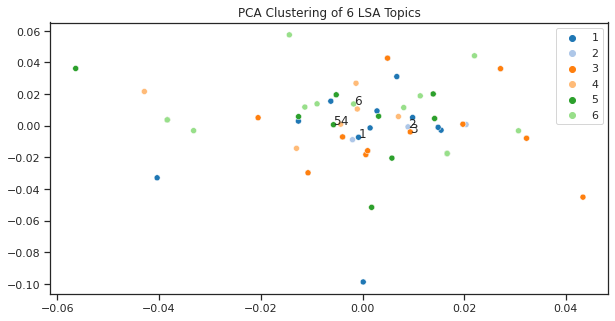

In [181]:
display_plot(x, y, hue_topics, colors, mean_vectors, labels,
             'PCA Clustering of {} LSA Topics'.format(n_topics_plot))

### t-SNE

In [182]:
tsne_lsa_model = TSNE(perplexity=2, random_state=42)

In [183]:
tsne_lsa_vectors = tsne_lsa_model.fit_transform(scaled_V)
tsne_lsa_vectors.shape

(2000, 2)

In [184]:
x2, y2, hue_topics2, mean_vectors2, labels2 = get_topic_vectors(n_topics_plot,
                                                           topics_terms,
                                                           tsne_lsa_vectors,
                                                           n_terms_plot, 1)

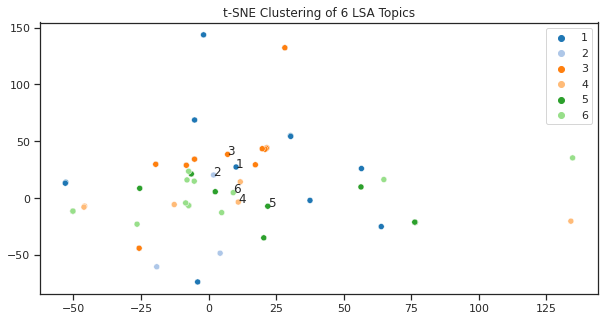

In [185]:
display_plot(x2, y2, hue_topics2, colors, mean_vectors2, labels2,
             't-SNE Clustering of {} LSA Topics'.format(n_topics_plot))

### UMAP

In [186]:
reducer = umap.UMAP(n_neighbors=2)

In [187]:
umap_lsa_vectors = reducer.fit_transform(scaled_V)
umap_lsa_vectors.shape

(2000, 2)

In [188]:
x3, y3, hue_topics3, mean_vectors3, labels3 = get_topic_vectors(n_topics_plot,
                                                           topics_terms,
                                                           umap_lsa_vectors,
                                                           n_terms_plot, 1)

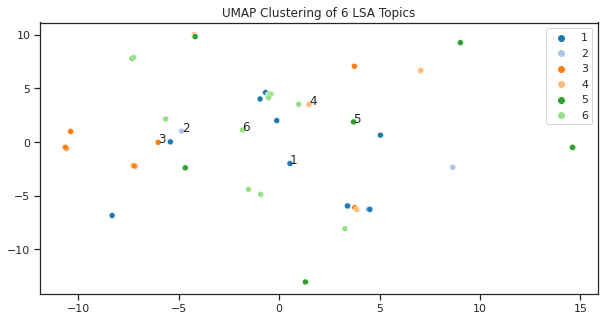

In [189]:
display_plot(x3, y3, hue_topics3, colors, mean_vectors3, labels3,
             'UMAP Clustering of {} LSA Topics'.format(n_topics_plot))

## 10. Conclusion 